In [78]:
import json
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor
import os

In [ ]:
# # Create necessary directories
# os.makedirs('data/processed', exist_ok=True)
# os.makedirs('results', exist_ok=True)
# os.makedirs('images', exist_ok=True)

In [80]:
# Load documents from processed JSON file
with open('../data/processed/documents-with-ids.json', 'r') as f:
    documents = json.load(f)

# Load ground truth dataset for evaluation from CSV file
df_ground_truth = pd.read_csv('../data/processed/ground-truth-retrieval.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

print(f"Loaded {len(documents)} documents and {len(ground_truth)} ground truth questions")

Loaded 149 documents and 735 ground truth questions


In [81]:
documents[10]

{'location': 'Andhra_Pradesh',
 'doc_id': 'd4402d82c0',
 'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
 'id': '450a9d36'}

In [92]:
ground_truth[10]

{'question': 'What are the must-see religious temples to visit in Andhra Pradesh?',
 'id': 'db0beb52'}

In [84]:
# Create a merged dataframe by joining ground-truth with documents on 'id' column
df_documents = pd.DataFrame(documents)
df_merged = df_ground_truth.merge(df_documents, on='id', how='inner')
merged_data = df_merged.to_dict(orient='records')
with open('../data/processed/ques-docs-pairs.json', 'w') as f:
    json.dump(merged_data, f, indent=2)
    
print(f"Created merged dataset with {len(merged_data)} question-document pairs")
print(f"Sample merged record keys: {list(merged_data[0].keys()) if merged_data else 'No data'}")

Created merged dataset with 745 question-document pairs
Sample merged record keys: ['question', 'id', 'location', 'doc_id', 'content']


In [86]:
# Create document index for quick lookup
doc_idx = {d['id']: d for d in documents}

In [95]:
doc_idx['db0beb52']['content']

'Northern Coast (Alluri Sitharama Raju, Anakapalli, East Godavari, Kakinada, Konaseema, Parvathipuram Manyam, Srikakulam, Visakhapatnam, Vizianagaram, Yanam) Central Coast (Eluru, Krishna, NTR, West Godavari) Southern Coast (Bapatla, Guntur, Nellore, Palnadu, Prakasam, Tirupati) Rayalaseema (Annamayya, Anantapur, Chittoor, Kadapa, Kurnool, Nandyal, Sri Sathya Sai)  \n![0_image_1.png](0_image_1.png) interactive map'

 #### Index data

In [ ]:
# We'll generate embeddings using [the sentence transformers](https://sbert.net/) library, if you don't have it, install it with pip:
# !pip install sentence-transformers

In [96]:
# Initialize sentence transformer model
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [97]:
# Generate vectors for all documents
vectors = []
for doc in tqdm(documents):
    # Use content field instead of question + text
    content = doc['content']
    vector = model.encode(content)
    vectors.append(vector)

vectors = np.array(vectors)

  0%|          | 0/149 [00:00<?, ?it/s]

In [98]:
# Create vector search index
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['location'])
vindex.fit(vectors, documents)

### Retrieval


In [99]:
def minsearch_vector_search(vector, location):
    return vindex.search(
        vector,
        filter_dict={'location': location},
        num_results=5
    )

def question_text_vector(q):
    question = q['question']
    location = q.get('location', None)  # Get location if available, otherwise None
    v_q = model.encode(question)
    
    if location:
        return minsearch_vector_search(v_q, location)
    else:
        # If no location specified, search without filter
        return vindex.search(v_q, num_results=5)

In [113]:
# Test vector search functionality
test_question = {
    'question': 'What are the must-see religious sites in Andhra Pradesh?',
}
search_results = question_text_vector(test_question)
print(f"Found {len(search_results)} relevant documents")

Found 5 relevant documents


In [114]:
search_results

[{'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': 'Andhra Pradesh (AP) is a state in Southern India, with Bay of Bengal on the east and shares boundaries with Telangana on the north, Chhattisgarh and Odisha on the north-east, Tamil Nadu on the south and Karnataka on the west. Vijayawada is the capital of this state.',
  'id': 'a411c9aa'},
 {'location': 'Andhra_Pradesh',
  'doc_id': 'd4402d82c0',
  'content': "Andhra Pradesh is known for its rich history, architecture and culture. Andhra Pradesh has a variety of tourist attractions including beaches, hills, wildlife, forests and temples. Like rest of the Southern India, the culture of Andhra Pradesh is essentially Dravidian, quite different from North India's Sanskrit Hindu culture. Andhra Pradesh was part of the British Madras presidency and then independent India's Madras State until 1953, when Andhra State was formed, with the capital being",
  'id': '450a9d36'},
 {'location': 'Andhra_Pradesh',
  'doc_id': '9eb52

#### The RAG flow with Travel Assistant Prompt

In [115]:
def build_prompt(query, search_results):
    prompt_template = """
You're a travel assistant bot that helps users plan their itinerary and discover amazing places to visit.
Answer the QUESTION based on the CONTEXT from the travel database.
Use only the facts from the CONTEXT when answering the QUESTION.

When answering, consider:
- Must-visit tourist attractions and landmarks
- Cultural experiences and local traditions  
- Historical significance of places
- Best times to visit and travel tips
- Local cuisine and specialties (if mentioned in context)
- Transportation and accessibility information (if available)

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    for doc in search_results:
        location = doc.get('location', 'Unknown')
        content = doc.get('content', doc.get('text', ''))  # Handle both content and text fields
        context = context + f"location: {location}\ncontent: {content}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [116]:
# Initialize OpenAI client
client = OpenAI()

In [117]:
def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [118]:
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

#### Single Example Evaluation Across All Models

In [134]:
ground_truth[10]

{'question': 'What are the must-see religious temples to visit in Andhra Pradesh?',
 'id': 'db0beb52'}

In [135]:
# Select a single example for evaluation across all models
sample_question = ground_truth[10]  # using a random question
print("Selected question for evaluation:")
print(f"Question: {sample_question['question']}")
print(f"Document ID: {sample_question['id']}")

Selected question for evaluation:
Question: What are the must-see religious temples to visit in Andhra Pradesh?
Document ID: db0beb52


In [136]:
# Get original answer from merged data or documents
doc_id = sample_question['id']
original_doc = doc_idx[doc_id]
answer_orig = original_doc['content']  # Use 'content' field instead of 'text'
sample_location = original_doc.get('location', 'Unknown')

In [137]:
print(f"Location: {sample_location}")
print(f"Original Content: {answer_orig[:200]}...")

Location: Andhra_Pradesh
Original Content: Northern Coast (Alluri Sitharama Raju, Anakapalli, East Godavari, Kakinada, Konaseema, Parvathipuram Manyam, Srikakulam, Visakhapatnam, Vizianagaram, Yanam) Central Coast (Eluru, Krishna, NTR, West Go...


In [138]:
# Prepare the question dict for RAG
sample_question_dict = {
    'question': sample_question['question'],
    'location': sample_location,
    'id': doc_id
}

In [139]:
# Test all GPT models on the single example
models_to_test = ['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini']
single_example_results = []

for model_name in models_to_test:
    print(f"\nTesting model: {model_name}")
    try:
        answer_llm = rag(sample_question_dict, model=model_name)
        
        result = {
            'model': model_name,
            'question': sample_question_dict['question'],
            'location': sample_location,
            'document_id': doc_id,
            'answer_orig': answer_orig,
            'answer_llm': answer_llm
        }
        single_example_results.append(result)
        print(f"Generated Answer: {answer_llm[:200]}...")
        
    except Exception as e:
        print(f"Error with model {model_name}: {e}")


Testing model: gpt-3.5-turbo
Generated Answer: Some of the must-see religious temples to visit in Andhra Pradesh include:

1. Tirupati - Known as the spiritual capital of Andhra Pradesh, with a sacred temple on the Tirumala Hills.
2. Amaravati - T...

Testing model: gpt-4o
Generated Answer: In Andhra Pradesh, one must-see religious temple is the sacred temple on the Tirumala Hills in Tirupati, which is known as the spiritual capital of the state. Tirupati is renowned for its significant ...

Testing model: gpt-4o-mini
Generated Answer: In Andhra Pradesh, there are several must-see religious temples that you should consider visiting:

1. **Tirumala Temple**: Located in Tirupati, this sacred temple on the Tirumala Hills is known as th...


In [140]:
# Save single example results
df_single_example = pd.DataFrame(single_example_results)
display(df_single_example)

,model,question,location,document_id,answer_orig,answer_llm
0,gpt-3.5-turbo,What are the must-see religious temples to vis...,Andhra_Pradesh,db0beb52,"Northern Coast (Alluri Sitharama Raju, Anakapa...",Some of the must-see religious temples to visi...
1,gpt-4o,What are the must-see religious temples to vis...,Andhra_Pradesh,db0beb52,"Northern Coast (Alluri Sitharama Raju, Anakapa...","In Andhra Pradesh, one must-see religious temp..."
2,gpt-4o-mini,What are the must-see religious temples to vis...,Andhra_Pradesh,db0beb52,"Northern Coast (Alluri Sitharama Raju, Anakapa...","In Andhra Pradesh, there are several must-see ..."


In [142]:
df_single_example.to_csv('../results/single_example_comparison.csv', index=False)
print("Saved single example results to: results/single_example_comparison.csv")

Saved single example results to: results/single_example_comparison.csv


#### Cosine Similarity Metric 

In [143]:
def compute_similarity(record):
    """Calculate cosine similarity between original and LLM answers"""
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [144]:
# Calculate cosine similarities for all models
cosine_similarities = []

for result in single_example_results:
    similarity = compute_similarity(result)
    cosine_similarities.append({
        'model': result['model'],
        'cosine_similarity': similarity,
        'question': result['question']
    })
    print(f"{result['model']}: {similarity:.4f}")

gpt-3.5-turbo: 0.3891
gpt-4o: 0.3621
gpt-4o-mini: 0.3734


C:\Users\Adi\AppData\Local\Temp\ipykernel_27776\128967923.py:51: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Adi\AppData\Local\Temp\ipykernel_27776\128967923.py:51: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Adi\AppData\Local\Temp\ipykernel_27776\128967923.py:51: UserWarning: Glyph 129352 (\N{SECOND PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Adi\AppData\Local\Temp\ipykernel_27776\128967923.py:52: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.savefig('../images/cosine_similarity_comparison.png', dpi=300, bbox_inches='tight',
C:\Users\Adi\AppData\Local\Temp\ipykernel_27776\128967923.py:52: UserWarning: Glyph 129353 (\N{THIRD PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.savefig('../images/cosine_similarity_comparison.png', dpi=300, bbox_inches='tight',
C:\Users\Ad

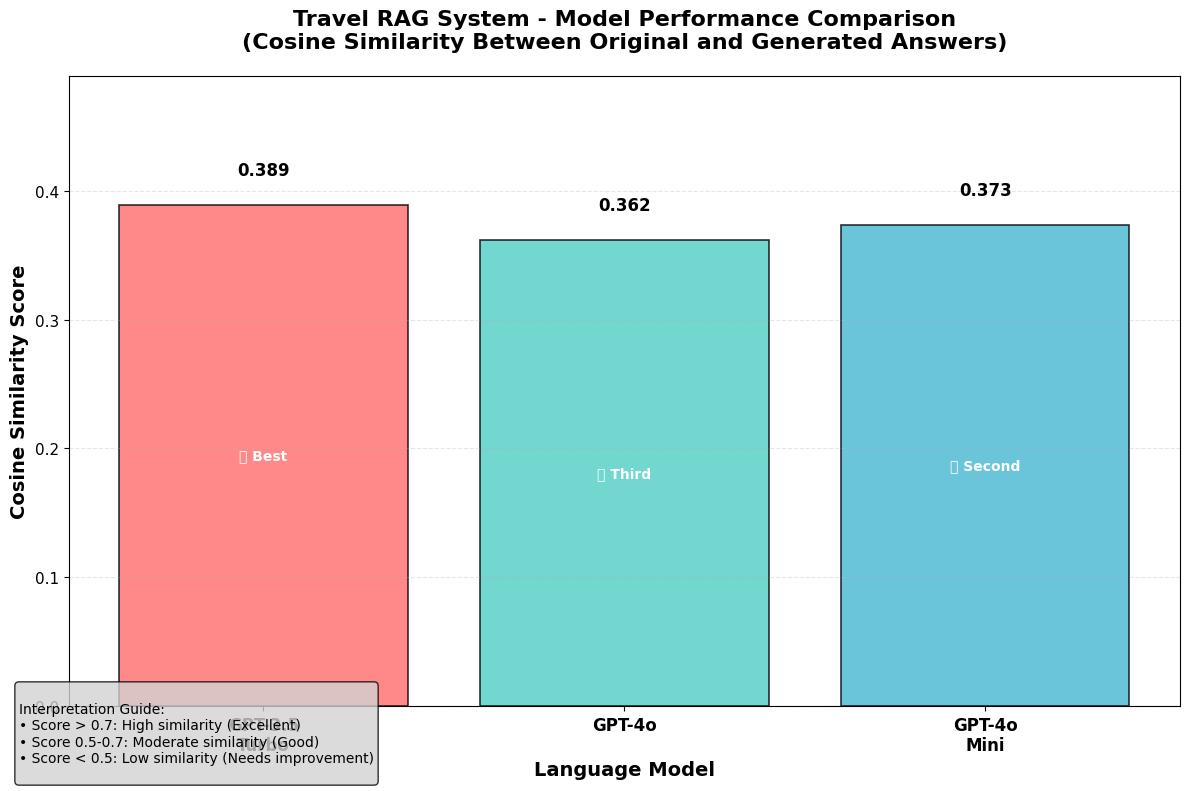

In [148]:
# Create visualization for cosine similarities
df_similarities = pd.DataFrame(cosine_similarities)

plt.figure(figsize=(12, 8))
plt.style.use('default')  # Use default matplotlib style

# Create bar chart with custom colors
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(df_similarities['model'], df_similarities['cosine_similarity'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the chart
plt.title('Travel RAG System - Model Performance Comparison\n(Cosine Similarity Between Original and Generated Answers)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Language Model', fontsize=14, fontweight='bold')
plt.ylabel('Cosine Similarity Score', fontsize=14, fontweight='bold')
plt.ylim(0, max(df_similarities['cosine_similarity']) + 0.1)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars with better formatting
for i, (bar, similarity) in enumerate(zip(bars, df_similarities['cosine_similarity'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{similarity:.3f}', ha='center', va='bottom', 
             fontsize=12, fontweight='bold')
    
    # Add rank labels
    rank_labels = ['🥇 Best', '🥈 Second', '🥉 Third']
    if i < len(rank_labels):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                 rank_labels[sorted(enumerate(df_similarities['cosine_similarity']), 
                                   key=lambda x: x[1], reverse=True).index((i, similarity))], 
                 ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Improve x-axis labels
model_labels = ['GPT-3.5\nTurbo', 'GPT-4o', 'GPT-4o\nMini']
plt.xticks(range(len(df_similarities)), model_labels, fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)

# Add interpretation guide
interpretation_text = """
Interpretation Guide:
• Score > 0.7: High similarity (Excellent)
• Score 0.5-0.7: Moderate similarity (Good)  
• Score < 0.5: Low similarity (Needs improvement)
"""
plt.figtext(0.02, 0.02, interpretation_text, fontsize=10, ha='left', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.savefig('../images/cosine_similarity_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

In [149]:
# Save similarities to CSV
df_similarities.to_csv('../results/cosine_similarities.csv', index=False)

#### LLM-as-a-Judge Evaluation

In [151]:
# LLM-as-a-Judge evaluation prompts
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [152]:
# Evaluate all models using LLM-as-a-Judge (A>Q>A evaluation)
evaluations_aqa = []

for result in single_example_results:
    prompt = prompt1_template.format(**result)
    evaluation_str = llm(prompt, model='gpt-4o-mini')
    
    try:
        evaluation = json.loads(evaluation_str)
        evaluation['model'] = result['model']
        evaluation['evaluation_type'] = 'Answer-Question-Answer'
        evaluations_aqa.append(evaluation)
    except json.JSONDecodeError:
        print(f"Failed to parse evaluation for model {result['model']}")

In [153]:
# Combine all evaluations
all_evaluations = evaluations_aqa + evaluations_qa
df_evaluations = pd.DataFrame(all_evaluations)

NameError: name 'evaluations_qa' is not defined

In [ ]:
# Display evaluation results
print("LLM-as-a-Judge Evaluation Results:")
print(df_evaluations[['model', 'evaluation_type', 'Relevance', 'Explanation']])

In [ ]:
# Save LLM-as-a-Judge evaluations
df_evaluations.to_csv('../results/llm_judge_evaluations.csv', index=False)

In [ ]:
# Create visualization for LLM-as-a-Judge results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

In [ ]:
# Plot AQA evaluations
aqa_data = df_evaluations[df_evaluations['evaluation_type'] == 'Answer-Question-Answer']
aqa_counts = aqa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
aqa_counts.plot(kind='bar', ax=ax1, title='Answer-Question-Answer Evaluation')
ax1.set_xlabel('Model')
ax1.set_ylabel('Count')
ax1.legend(title='Relevance')
ax1.tick_params(axis='x', rotation=45)

In [ ]:
# Plot QA evaluations
qa_data = df_evaluations[df_evaluations['evaluation_type'] == 'Question-Answer']
qa_counts = qa_data.groupby(['model', 'Relevance']).size().unstack(fill_value=0)
qa_counts.plot(kind='bar', ax=ax2, title='Question-Answer Evaluation')
ax2.set_xlabel('Model')
ax2.set_ylabel('Count')
ax2.legend(title='Relevance')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../images/llm_judge_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

#### Summary Results

In [ ]:
# Create summary report
print("=== EVALUATION SUMMARY ===")
print("\n1. COSINE SIMILARITY SCORES:")
for _, row in df_similarities.iterrows():
    print(f"   {row['model']}: {row['cosine_similarity']:.4f}")

print("\n2. LLM-as-a-JUDGE EVALUATIONS:")
print("\n   Answer-Question-Answer Relevance:")
for _, row in aqa_data.iterrows():
    print(f"   {row['model']}: {row['Relevance']}")

print("\n   Question-Answer Relevance:")
for _, row in qa_data.iterrows():
    print(f"   {row['model']}: {row['Relevance']}")

print("\n3. FILES GENERATED:")
print("   - results/single_example_comparison.csv")
print("   - results/cosine_similarities.csv") 
print("   - results/llm_judge_evaluations.csv")
print("   - images/cosine_similarity_comparison.png")
print("   - images/llm_judge_evaluation.png")
print("   - data/processed/ques-docs-pairs.json")